## 1. Sentiment Analysis - EDA on Airline Tweets
---

### Contents:
- [Exploratory Data Analysis](#EDA)
- [Data Preprocessing](#Preprocessing)
- [EDA Visualisations](#Visualisations)
- [Further Data Preprocessing/Cleaning](#Preprocessing2)


In [178]:
#importing libraries 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

import re 
import emoji        # !pip install emoji
from emot.emo_unicode import UNICODE_EMO, EMOTICONS   # !pip install emot 
import textblob     # !pip install textblob

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from os import path
from PIL import Image

from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [179]:
pd.set_option('display.max_columns',150)
pd.set_option('display.max_rows',1500)

<a id='EDA'></a>

## EDA & Pre-processing
---

##### The following were analysed:
1. Distribution of tweets by sentiment; it seems like people with negative comments tend to post more commonly
2. Content of tweets that people post; includes links, emojis, retweets 
3. Types of tweets; ham vs spam? common spam includes tweets that ask accounts to follow back
4. Twitter has a max character limit of 140 
5. Visualisation of most common words and bigrams based on sentiment


In [180]:
filepath = '../datasets/tweets.csv'

In [181]:
tweets = pd.read_csv(filepath)

In [182]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [183]:
tweets.loc[246]['text']

'@VirginAmerica Thanks for your great customer service today &amp; for helping me get all my travel sorted out!'

In [184]:
tweets.loc[781]['text']

'@united you too!'

In [185]:
tweets.loc[1444]['text']

'@united flight 435'

In [186]:
tweets.loc[1644]['text']

'@united now this http://t.co/uygeW2Nosr'

In [187]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [188]:
tweets.shape

(14640, 15)

In [189]:
#target column is airline_sentiment, where we have 3 classes : positive, negative, neutral
#majority of the entries for airline_sentiment_gold and negativereason_gold were empty (14600 out of 14640) hence these columns will not be used
#tweet coordinates are typically blank and will be ignored 

In [190]:
tweets.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [191]:
#dropping airline_sentiment_gold,negativereason_gold,tweet_coord

tweets.drop(columns=['airline_sentiment_gold','negativereason_gold','tweet_coord'], axis=1, inplace=True)

In [192]:
tweets[tweets.duplicated()].head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
12040,570308309682675712,negative,1.0,Customer Service Issue,1.0,American,SweeLoTmac,0,@AmericanAir why would I even consider continu...,2015-02-24 11:44:31 -0800,NaN,Quito
12059,570305051819941889,neutral,1.0,NaN,NaN,American,Chandrafaythe,0,@AmericanAir my flight got Cancelled Flightled...,2015-02-24 11:31:34 -0800,NaN,Quito
12063,570303383782989824,neutral,1.0,NaN,NaN,American,trentgillaspie,0,.@AmericanAir just disappointed with the Fligh...,2015-02-24 11:24:57 -0800,"Austin, but often Denver",Mountain Time (US & Canada)
12066,570301929580048385,neutral,1.0,NaN,NaN,American,FinEdChat,0,@AmericanAir I did,2015-02-24 11:19:10 -0800,"Cincinnati, Ohio",Atlantic Time (Canada)
12068,570301395141836801,negative,1.0,Late Flight,1.0,American,JoBarredaV,1,@AmericanAir r u serious?? 304min #delay with ...,2015-02-24 11:17:02 -0800,Mexico City,Central Time (US & Canada)


In [193]:
tweets[tweets['airline_sentiment'] =='neutral'][['text','name']]

,text,name
0,@VirginAmerica What @dhepburn said.,cairdin
2,@VirginAmerica I didn't today... Must mean I n...,yvonnalynn
7,@VirginAmerica Really missed a prime opportuni...,pilot
10,@VirginAmerica did you know that suicide is th...,idk_but_youtube
23,@VirginAmerica will you be making BOS&gt;LAS n...,rjlynch21086
...,...,...
14607,@AmericanAir i need someone to help me out,WishUpon_26
14611,"@AmericanAir guarantee no retribution? If so, ...",TrueChief77
14632,"“@AmericanAir: @TilleyMonsta George, that does...",Chad_SMFYM
14637,@AmericanAir Please bring American Airlines to...,sanyabun


In [194]:
duplicates = tweets[tweets.duplicated()].index

In [195]:
len(duplicates)

39

In [196]:
#duplicate tweets will be dropped 
tweets.drop(index=duplicates,inplace=True)

#check if 39 rows were dropped
tweets.shape

(14601, 12)

### All JetBlue Posts Misclassfied as Delta

- The text of tweets corresponding to Delta all have the tag @JetBlue / @jetblue

In [220]:
tweets[tweets['airline'] =='Delta'][['text','airline']]

,text,airline
6746,@JetBlue Yesterday on my way from EWR to FLL j...,Delta
6747,@JetBlue I hope so because I fly very often an...,Delta
6748,"@JetBlue flight 1041 to Savannah, GA",Delta
6749,"@JetBlue They weren't on any flight, they just...",Delta
6750,@JetBlue everyone is here but our pilots are n...,Delta
...,...,...
8963,"@JetBlue CEO weighs profits, flyers - @Chronic...",Delta
8964,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,Delta
8965,@JetBlue's new CEO seeks the right balance to ...,Delta
12038,@DeltaAssist now at 57 minutes waiting on Silv...,Delta


In [224]:
delta = tweets[tweets['airline']=='Delta']

In [237]:
jetblue_count=0
for i, text in enumerate(delta['text']):
    if '@JetBlue' or '@jetblue' in text:
        jetblue_count += 1 

jetblue_count

2222

### Overiew of number of retweets

- Most tweets are not reposted

In [197]:
tweets['retweet_count'].value_counts()

0     13835
1       639
2        66
3        22
4        17
5         5
7         3
6         3
22        2
8         1
32        1
9         1
31        1
18        1
15        1
28        1
44        1
11        1
Name: retweet_count, dtype: int64

### Overiew of Tweets by Sentiment

- Unbalanced classes with majority being negative sentiments

negative    0.627149
neutral     0.211698
positive    0.161153
Name: airline_sentiment, dtype: float64


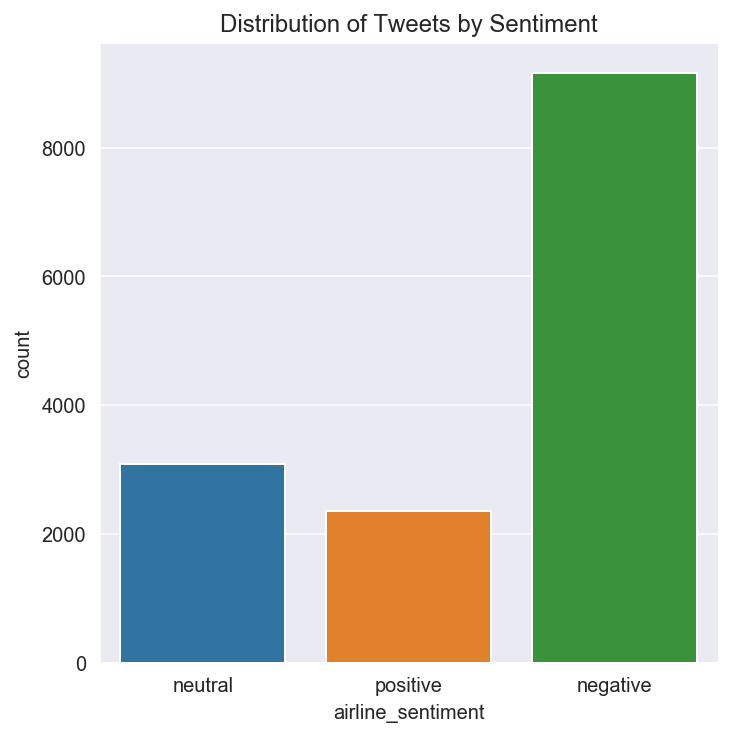

In [198]:
#unbalanced classes with majority having negative sentiments
print(tweets['airline_sentiment'].value_counts(normalize=True))

#distribution of tweets by sentiment
sns.catplot(x='airline_sentiment',kind='count',data=tweets)
plt.title('Distribution of Tweets by Sentiment');

plt.savefig('../figure/TweetBySentiment')

### Overiew of Tweets by Airline

- Least number of tweets for Virgin America, the rest have a fairly balanced number of tweets in the range of 2000 to 3900

United            3822
US Airways        2913
American          2720
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64


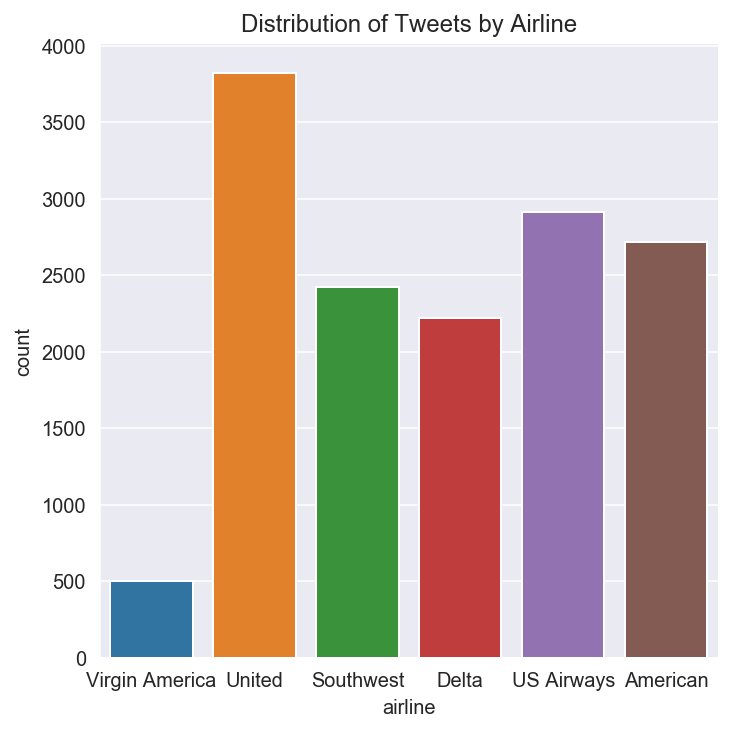

In [199]:
#number of tweets by airline
print(tweets['airline'].value_counts())

#distribution of tweets by airline
sns.catplot(x='airline',kind='count',data=tweets)
plt.title('Distribution of Tweets by Airline');

plt.savefig('../figure/TweetByAirline')

- United, US Airways and American have the highest number of tweets and are also the top 3 with the most number of negative tweets

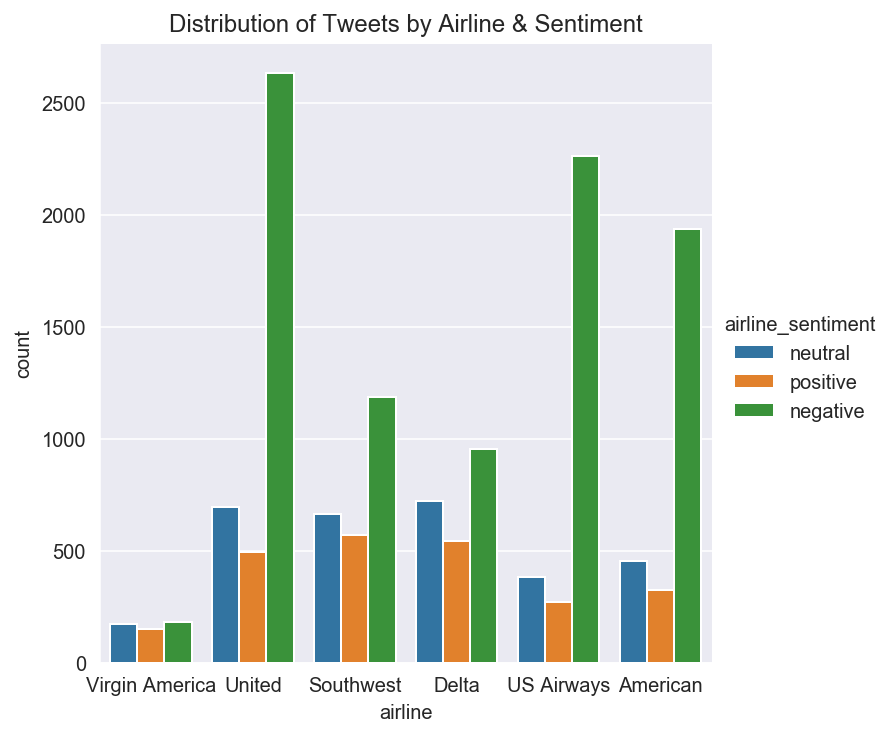

In [200]:
#distribution of tweets by airline and sentiment
sns.catplot(x='airline',kind='count',data=tweets,hue='airline_sentiment')
plt.title('Distribution of Tweets by Airline & Sentiment');

plt.savefig('../figure/TweetByAirline&Sentiment')

In [201]:
# value = tweets.groupby(by='airline')['airline_sentiment'].value_counts()
# pd.DataFrame(value)[['airline_sentiment']]

In [202]:
# tweets.groupby(by='airline')['airline_sentiment'].value_counts().plot(kind='bar',stacked=True)

### Overiew of Tweets by User

- There seems to be multiple posts by the same user, as such I shall delve deeper for some understanding

In [203]:
#unbalanced classes with majority having negative sentiments
tweets['name'].value_counts()

JetBlueNews    63
kbosspotter    32
_mhertz        29
otisday        28
throthra       27
               ..
AArt763         1
wxmario         1
statepkt        1
AzeenaW         1
ashtongr8z      1
Name: name, Length: 7701, dtype: int64

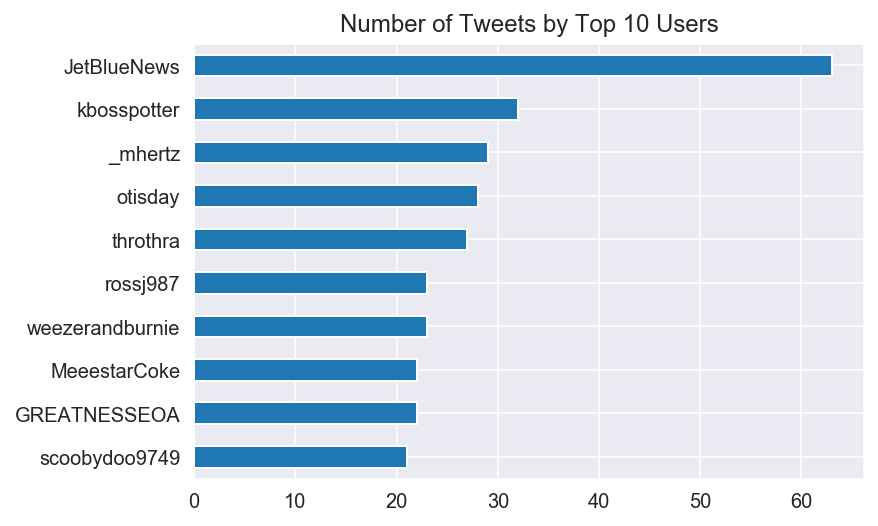

In [204]:
tweets['name'].value_counts().head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Number of Tweets by Top 10 Users');

#### There are clearly different types of users, we have the news channel (organisations).. 

- Looking at the neutral tweets by user JetBlueNews, most of them seem to be new reports -> hence sentiment is neutral

In [205]:
#63 posts from jetbluenews but they are mainly tagged as Delta even thought they refer to JetBlue Airlines
#will leave the posts as it is as the main aim is to classify them by sentiment

tweets[(tweets['name']=='JetBlueNews') & (tweets['airline_sentiment'] =='neutral')].head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
296,568833739192557569,neutral,1.000,NaN,NaN,Virgin America,JetBlueNews,0,@VirginAmerica achieves a second year of profi...,2015-02-20 10:05:06 -0800,USA,Sydney
7860,569158629443502081,neutral,0.667,NaN,NaN,Delta,JetBlueNews,0,@JetBlue Fliers to Gain Access to WSJ Content ...,2015-02-21 07:36:06 -0800,USA,Sydney
7867,569150828952444928,neutral,1.000,NaN,NaN,Delta,JetBlueNews,0,@JetBlue Airways Now Covered by Bank of Americ...,2015-02-21 07:05:06 -0800,USA,Sydney
7872,569143528397254656,neutral,1.000,NaN,NaN,Delta,JetBlueNews,0,@JetBlue Airways Stock Rating Lowered by Vetr ...,2015-02-21 06:36:06 -0800,USA,Sydney
7884,569113328724807680,neutral,1.000,NaN,NaN,Delta,JetBlueNews,0,@JetBlue's CEO battles to appease passengers a...,2015-02-21 04:36:05 -0800,USA,Sydney


In [206]:
tweets[(tweets['name']=='JetBlueNews') & (tweets['airline_sentiment'] =='neutral')]['text'][7860]

'@JetBlue Fliers to Gain Access to WSJ Content - Analyst Blog - Nasdaq http://t.co/dWEse7Xidr'

In [207]:
tweets[(tweets['name']=='JetBlueNews') & (tweets['airline_sentiment'] =='neutral')]['text'][7872]

'@JetBlue Airways Stock Rating Lowered by Vetr Inc. (JBLU) - Dakota Financial News http://t.co/QW2eBEEMVg'

In [208]:
tweets[(tweets['name']=='JetBlueNews') & (tweets['airline_sentiment'] =='neutral')]['text'][8868]

"@JetBlue's new CEO Robin Hayes battles to appease passengers and Wall Street - Business In Savannah http://t.co/KKAY8XaPs1"

#### There are clearly different types of users..

- Looking at the tweets by user kbosspotter, some tweets are mainly related to queries and some troll messages

In [209]:
tweets[tweets['name']=='kbosspotter'].head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
6752,570304873620746240,neutral,0.6939,NaN,NaN,Delta,kbosspotter,0,@JetBlue check DM please :),2015-02-24 11:30:52 -0800,Logan International Airport,Atlantic Time (Canada)
6853,570179466716176384,positive,0.6737,NaN,NaN,Delta,kbosspotter,0,@JetBlue haha. TY. Do you know what time that ...,2015-02-24 03:12:32 -0800,Logan International Airport,Atlantic Time (Canada)
6894,570050603851710464,neutral,0.6857,NaN,NaN,Delta,kbosspotter,0,@JetBlue I can't find a good photo of it... Yo...,2015-02-23 18:40:29 -0800,Logan International Airport,Atlantic Time (Canada)
6896,570049018820042752,positive,1.0000,NaN,NaN,Delta,kbosspotter,0,"@JetBlue I like "" Follow @JetBlue """,2015-02-23 18:34:11 -0800,Logan International Airport,Atlantic Time (Canada)
6897,570048915518533634,neutral,0.6514,NaN,NaN,Delta,kbosspotter,0,@JetBlue or she ;),2015-02-23 18:33:47 -0800,Logan International Airport,Atlantic Time (Canada)


In [210]:
index = tweets[(tweets['name']=='kbosspotter')].index
index = [int(i) for i in index]

for i in index[::-1]:
    print(i)
    print(tweets[(tweets['name']=='kbosspotter')]['text'][i])

8949
@JetBlue I have a internal bleed in my foot, and I am flying next Tuesday, what should I. Do :( these. Leeds come randomly. I
8945
@JetBlue no, I am fine to fly! Haha, they come at random, with the hemophilia, but what if i need extra assistance
8570
@JetBlue is it true there's a new A320 livery and a new website...?!
8569
@JetBlue BEST SEAT ON A E190 to board early. READY. SET. GO!
8568
@JetBlue I can't pay 30 bucks xD
8566
@JetBlue my mom wanted me to change her seat along with my sister, but their two different reservations and idk
8565
@JetBlue can't change it. True blue points and I can't get to a phone
8558
@JetBlue can you DM?
8409
@JetBlue is flight 51 on 4/24/15 moved back? When I booked it said we arrive 11:31 but now it says 12:08 😢
8297
@JetBlue I can't do that flight. I need a Late Flightr one! I need you to change my flight. You guys changed it and now I can't do that time!
8296
@JetBlue I can't. I don't have acces to a phone rn. My iPhone broke. :/ would rather chan

In [211]:
kbosspotter = tweets[(tweets['name']=='kbosspotter')]['tweet_created']
kbosspotter

6752    2015-02-24 11:30:52 -0800
6853    2015-02-24 03:12:32 -0800
6894    2015-02-23 18:40:29 -0800
6896    2015-02-23 18:34:11 -0800
6897    2015-02-23 18:33:47 -0800
6900    2015-02-23 18:29:54 -0800
6901    2015-02-23 18:28:45 -0800
6902    2015-02-23 18:26:24 -0800
7038    2015-02-23 11:55:30 -0800
7055    2015-02-23 11:50:07 -0800
7057    2015-02-23 11:46:43 -0800
7059    2015-02-23 11:44:52 -0800
7060    2015-02-23 11:42:39 -0800
7061    2015-02-23 11:42:22 -0800
7062    2015-02-23 11:40:32 -0800
7279    2015-02-22 19:18:17 -0800
7851    2015-02-21 09:17:56 -0800
7947    2015-02-20 17:26:56 -0800
8097    2015-02-20 07:36:30 -0800
8294    2015-02-19 13:37:11 -0800
8295    2015-02-19 13:33:39 -0800
8296    2015-02-19 13:26:12 -0800
8297    2015-02-19 13:23:53 -0800
8409    2015-02-19 06:26:22 -0800
8558    2015-02-18 13:53:39 -0800
8565    2015-02-18 13:28:41 -0800
8566    2015-02-18 13:26:46 -0800
8568    2015-02-18 13:22:52 -0800
8569    2015-02-18 13:19:23 -0800
8570    2015-0

In [212]:
#majority of the tweets are from US & Canada
tweets['user_timezone'].value_counts()

Eastern Time (US & Canada)     3738
Central Time (US & Canada)     1923
Pacific Time (US & Canada)     1206
Quito                           733
Atlantic Time (Canada)          496
Mountain Time (US & Canada)     366
Arizona                         228
London                          193
Alaska                          108
Sydney                          107
Hawaii                          104
Amsterdam                        74
America/Chicago                  37
America/New_York                 26
Indiana (East)                   26
Paris                            25
Abu Dhabi                        23
Brasilia                         23
Greenland                        17
Dublin                           17
Tehran                           17
Santiago                         17
Athens                           16
Mid-Atlantic                     15
Casablanca                       15
New Delhi                        15
America/Los_Angeles              15
Buenos Aires                

In [213]:
timezone = tweets[tweets['user_timezone'].notnull()]['user_timezone']

#### There are clearly different types of users..

- Spammers and those that ask for follows

In [214]:
for i,text in enumerate(tweets['text']):
    if '🙏' in text:
        print(i)
        print(text)

657
@united I know this is probably a no but is there a way to get a cheaper airfare ticket if the flight is leaving in a few hours? 🙏
2775
@united please tell me I'm going to make my connecting flight from O'hare to #STL #SouthBendINWhere 🙏 http://t.co/qGwK10dEwv
5720
@SouthwestAir when is the last chance to get #DestinationDragons tickets? I would die of happiness if I won 😭🙏
5856
@SouthwestAir do you have any tickets to the Atlanta show? I would love to go with my sister ♥️🙏
6358
@SouthwestAir I love and appreciate the fact that you guys rarely Cancelled Flight flights and are on time, but I need a Cancelled Flightlation this time. 🙏
7352
“@JetBlue: @FinleyBklynCFS So glad to hear. Thanks for sharing the video.” Me and JetBlue are #BFF 🙏
8453
@JetBlue #ClosePWCS please just tweet this🙏🙏❤️ I fly jetblue every time btw😏
8454
@JetBlue Can you do me a huge favor?!🙏❤️
9103
@USAirways I know this is probably a no but is there a way to get a cheaper airfare ticket if the flight is leaving 

In [215]:
for i,text in enumerate(tweets['text']):
    if '🙏' in text:
        print(i)
        print(text)
        print(tweets['name'][i])

657
@united I know this is probably a no but is there a way to get a cheaper airfare ticket if the flight is leaving in a few hours? 🙏
WhatSarahSayzz
2775
@united please tell me I'm going to make my connecting flight from O'hare to #STL #SouthBendINWhere 🙏 http://t.co/qGwK10dEwv
Heaton52
5720
@SouthwestAir when is the last chance to get #DestinationDragons tickets? I would die of happiness if I won 😭🙏
geekstiel
5856
@SouthwestAir do you have any tickets to the Atlanta show? I would love to go with my sister ♥️🙏
geekstiel
6358
@SouthwestAir I love and appreciate the fact that you guys rarely Cancelled Flight flights and are on time, but I need a Cancelled Flightlation this time. 🙏
torithompson13
7352
“@JetBlue: @FinleyBklynCFS So glad to hear. Thanks for sharing the video.” Me and JetBlue are #BFF 🙏
FinleyBklynCFS
8453
@JetBlue #ClosePWCS please just tweet this🙏🙏❤️ I fly jetblue every time btw😏
xcuteafi
8454
@JetBlue Can you do me a huge favor?!🙏❤️
xcuteafi
9103
@USAirways I know this i

In [243]:
for i,text in enumerate(tweets['text']):
    if 'fleet' in text:
        print(i)
        print(text)
#         print(tweets['name'][i])
#         print(tweets['airline_sentiment'][i])

826
@united UA938 ORD-LHR.  bags are being loaded 30min Late Flight. Frigid air into cabin! Plane feels like falling apart! Upgrade long haul fleet!
3001
@united - are you aware your airbus fleet sucks?  I'd rather fly a C-130 full of rubber dog shit.
3472
@united sure... You've been saying that for as long as I've been tweeting about your obsolete fleet.  Promises are free.
4507
@southwestair cool shot of the moon and one of your fleet http://t.co/kl9BAiMES6
4927
@SouthwestAir has a beautiful fleet. What a perfect evening to fly! http://t.co/XMZ3Tf9Ix8
6796
@CatfoodBeerGlue you'll enjoy this. 

“@JetBlue: Our fleet's on fleek. http://t.co/2thC9RKURT”
6801
“@JetBlue: Our fleet's on fleek. http://t.co/b5ttno68xu” I just 🙈
6808
Sigh... “@JetBlue: Our fleet's on fleek. http://t.co/W5NL0AY9Bl”
6814
“@JetBlue: Our fleet's on fleek. http://t.co/clu5pdPrHP” :(
6861
RT @JetBlue: Our fleet's on fleek. http://t.co/WEZUMDimYF
6881
“@JetBlue: Our fleet's on fleek. http://t.co/Vxn2J36M7V” this happ

### Distribution of Length of Tweets

- Twitter imposes a maximum number of characters for their tweets hence most of the tweets are in the range of 140 characters.

In [136]:
len(tweets['text'][20])

130

In [137]:
tweets['text'][20]

'@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???'

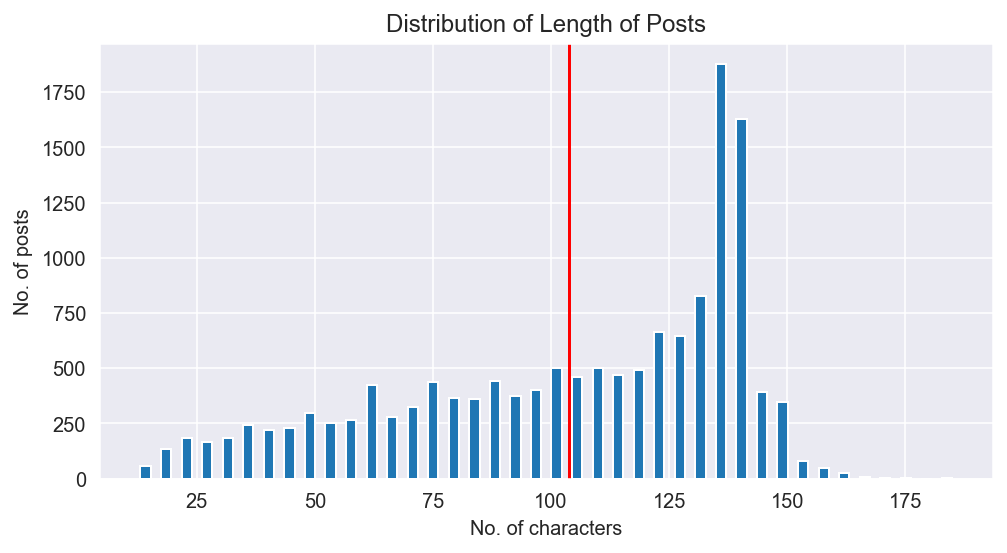

In [138]:
length = [len(text) for text in tweets['text']]

length_df = pd.DataFrame(length)

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(length, bins=40, rwidth=0.5)
plt.axvline(np.mean(length), color='red')
ax.set_title('Distribution of Length of Posts')
ax.set_xlabel('No. of characters')
ax.set_ylabel('No. of posts')
ax.grid(b=True)

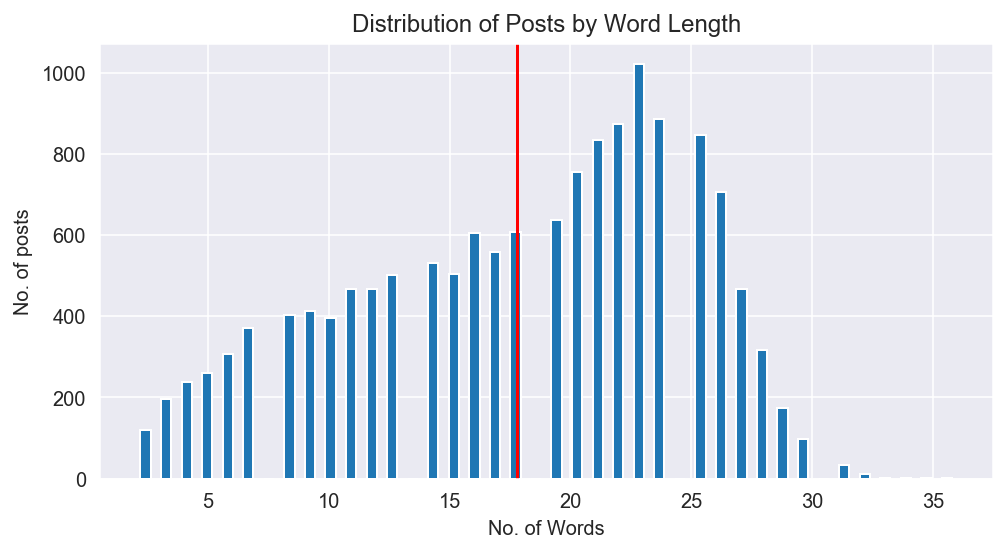

In [139]:
length = [len(text.split(" ")) for text in tweets['text']]

length_df = pd.DataFrame(length)

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(length, bins=40, rwidth=0.5)
plt.axvline(np.mean(length), color='red')
ax.set_title('Distribution of Posts by Word Length')
ax.set_xlabel('No. of Words')
ax.set_ylabel('No. of posts')
ax.grid(b=True)

### Preparing the data 

- Converting the classes into numerical format
- Only the text column will be used

In [140]:
tweets['airline_sentiment'] = tweets['airline_sentiment'].map({'negative':0,
                                                               'neutral':1,
                                                               'positive':2   
})

In [141]:
tweets_df = tweets[['airline_sentiment','text']]

In [142]:
tweets_df['text'].iloc[11436]

'@USAirways YOU ARE THE BEST!!! FOLLOW ME PLEASE;)🙏🙏🙏✌️✌️✌️🙏🙏🙏'

<a id='Preprocessing'></a>

### Data Pre-processing

##### Approach #1:

- Convert to lowercase
- Remove weblinks
- Remove airline tags (@, #??)
- Convert emojis to words using emoji library 
- Remove punctuations 
- Remove stopwords 
- Lemmatize & stem

In [143]:
lemmatizer = WordNetLemmatizer()
p_stemmer = PorterStemmer()

In [144]:
def review_text(text):
    
    #1. convert words to lower 
    text = text.lower()

    #2. remove weblinks 
    text =re.sub(r"http\S+","",str(text))

    #3. remove tags
    text =re.sub(r"@\S+","",str(text))
    
    #4. remove parses
    text =re.sub(r"&\S+","",str(text))

    #5. convert emoji to text
    text = emoji.demojize(text, delimiters=(" ", ""))

    #6. tokenize words 
    tokenizer = RegexpTokenizer('[a-z]\w+')
    words = tokenizer.tokenize(text)
    
    #7. remove stopwords
    #   convert stopwords to set, as searching a set is faster than a list
    addn_words=['flight']
    stops = stopwords.words('english')
    stops.extend(addn_words)
    
    meaningful_words = [w for w in words if w not in stops]
    
    #8. lemmatize words 
    lem_words = [lemmatizer.lemmatize(i) for i in meaningful_words]

    #9. stem words 
    stem_words = [p_stemmer.stem(i) for i in lem_words]
#     print(len(stem_words))
    
    #10. stem text 
    stem_text = " ".join(stem_words)
    
    #10. check for an empty string, which will be replaced with '0'
    if stem_text == "":
        stem_text = stem_text.replace("",'0')
    
    return (stem_text)

In [145]:
# text = '@JetBlue is flight 51 on 4/24/15 moved back? When I booked it said we arrive 11:31 but now it says 12:08 😢'

In [146]:
# text = review_text(text)
# print(len(text))
# text

In [147]:
# text2 = '@JetBlue is flight 51 on 4/24/15 moved back? When I booked it said we arrive 11:31 but now it says 12:08 😢😢'

In [148]:
# text2 = review_text(text2)
# print(len(text2))
# text2

In [149]:
text3 = '@USAirways YOU ARE THE BEST!!! FOLLOW ME PLEASE;)🙏🙏🙏✌️✌️✌️🙏🙏🙏'

In [150]:
text3 = review_text(text3)
print(len(text3))
text3

128


'best follow pleas folded_hand folded_hand folded_hand victory_hand victory_hand victory_hand folded_hand folded_hand folded_hand'

### Dafault Stopwords

- Taking a look at the default stopwords found in NLTK english
- Stopwords will be removed in the first round of modelling 

In [151]:
# stops = stopwords.words('english')
# stops

In [152]:
review_text(tweets.loc[246]['text'])

'thank great custom servic today help get travel sort'

In [153]:
review_text(tweets_df['text'][8868])

'new ceo robin hay battl appeas passeng wall street busi savannah'

In [154]:
review_text(tweets_df['text'][781])

'0'

In [155]:
tweets_clean = tweets_df['text'].apply(review_text)

In [156]:
tweets_clean

0                                                     said
1                             plu ad commerci experi tacki
2                     today must mean need take anoth trip
3        realli aggress blast obnoxi entertain guest fa...
4                                     realli big bad thing
                               ...                        
14635                             thank got differ chicago
14636    leav minut late warn commun minut late call sh...
14637             pleas bring american airlin blackberry10
14638         money chang answer phone suggest make commit
14639    ppl need know mani seat next plz put u standbi...
Name: text, Length: 14601, dtype: object

In [157]:
for i,text in enumerate(tweets_clean):
    if 'folded_hand' in text:
        print(i)
        print(text)

657
know probabl way get cheaper airfar ticket leav hour folded_hand
2775
pleas tell go make connect hare stl southbendinwher folded_hand
5720
last chanc get destinationdragon ticket would die happi loudly_crying_fac folded_hand
5856
ticket atlanta show would love go sister heart_suit folded_hand
6358
love appreci fact guy rare cancel flight time need cancel flightlat time folded_hand
7352
glad hear thank share video jetblu bff folded_hand
8453
closepwc pleas tweet folded_hand folded_hand red_heart fli jetblu everi time btw smirking_fac
8454
huge favor folded_hand red_heart
9103
know probabl way get cheaper airfar ticket leav hour folded_hand
9625
best amaz follow pleas folded_hand folded_hand folded_hand
11436
best follow pleas folded_hand folded_hand folded_hand victory_hand victory_hand victory_hand folded_hand folded_hand folded_hand
11498
amaz follow back pleas folded_hand folded_hand folded_hand folded_hand folded_hand folded_hand folded_hand folded_hand folded_hand folded_hand f

In [158]:
tweets_clean.isnull().value_counts()

False    14601
Name: text, dtype: int64

In [159]:
tweets_clean[781]

'0'

In [160]:
tweets_clean[1444]

'0'

In [161]:
tweets_clean[1644]

'0'

In [162]:
tweets_clean[1644] == ""

False

<a id='Visualisations'></a>

### Visualizations

#### EDA - Most Common Words (Top 20)

- Count Vectorizer to get most common words by sentiment

In [163]:
# Instantiate the "CountVectorizer" object
cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000) #this is maximum features, to get top 5000 words

In [164]:
# assigning the cleaned text to dataframe
tweets_df['clean_text'] = tweets_clean

#masking function for the 3 categories
positive = tweets_df[tweets_df['airline_sentiment']==2]
neutral = tweets_df[tweets_df['airline_sentiment']==1]
negative = tweets_df[tweets_df['airline_sentiment']==0]

#convert tweets text to a single text by category
positive_text = " ".join(text for text in positive['clean_text'])
neutral_text = " ".join(text for text in neutral['clean_text'])
negative_text = " ".join(text for text in negative['clean_text'])


C:\Users\leanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### EDA - word cloud for each sentiment

A word cloud was generated for each sentiment.

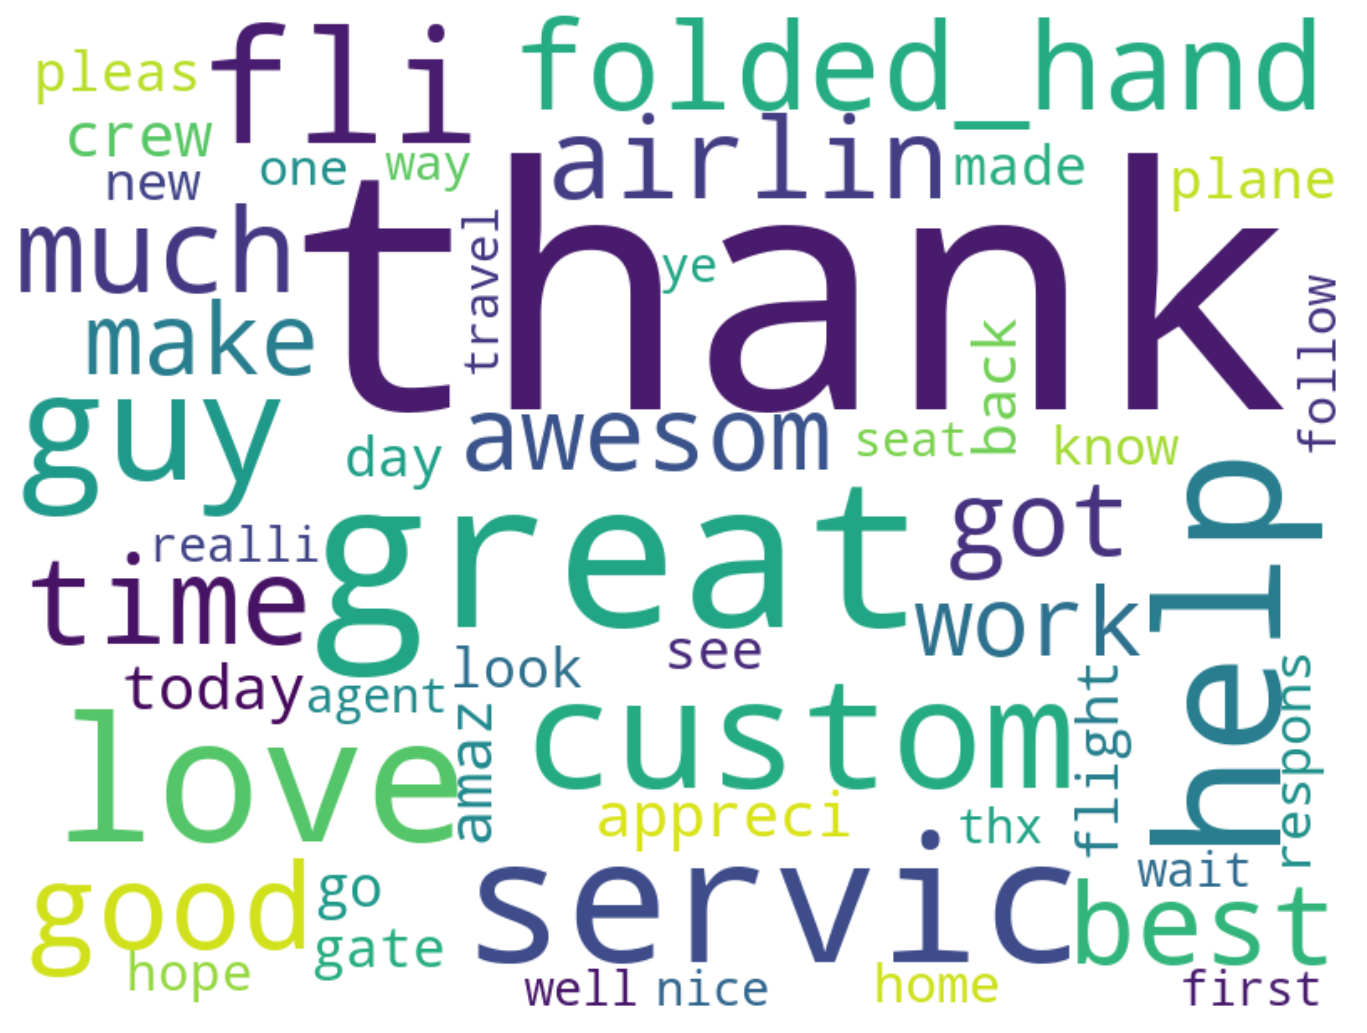

In [165]:
#plot word cloud for positive 
wc_pos = WordCloud(max_words=50, width=800, height=600, 
              background_color='white', min_font_size =10, collocations=False).generate(positive_text)

plt.figure(figsize=(12,12))
plt.imshow(wc_pos,interpolation='bilinear')
plt.axis("off")
plt.savefig('../figure/pos_wordcloud.png');

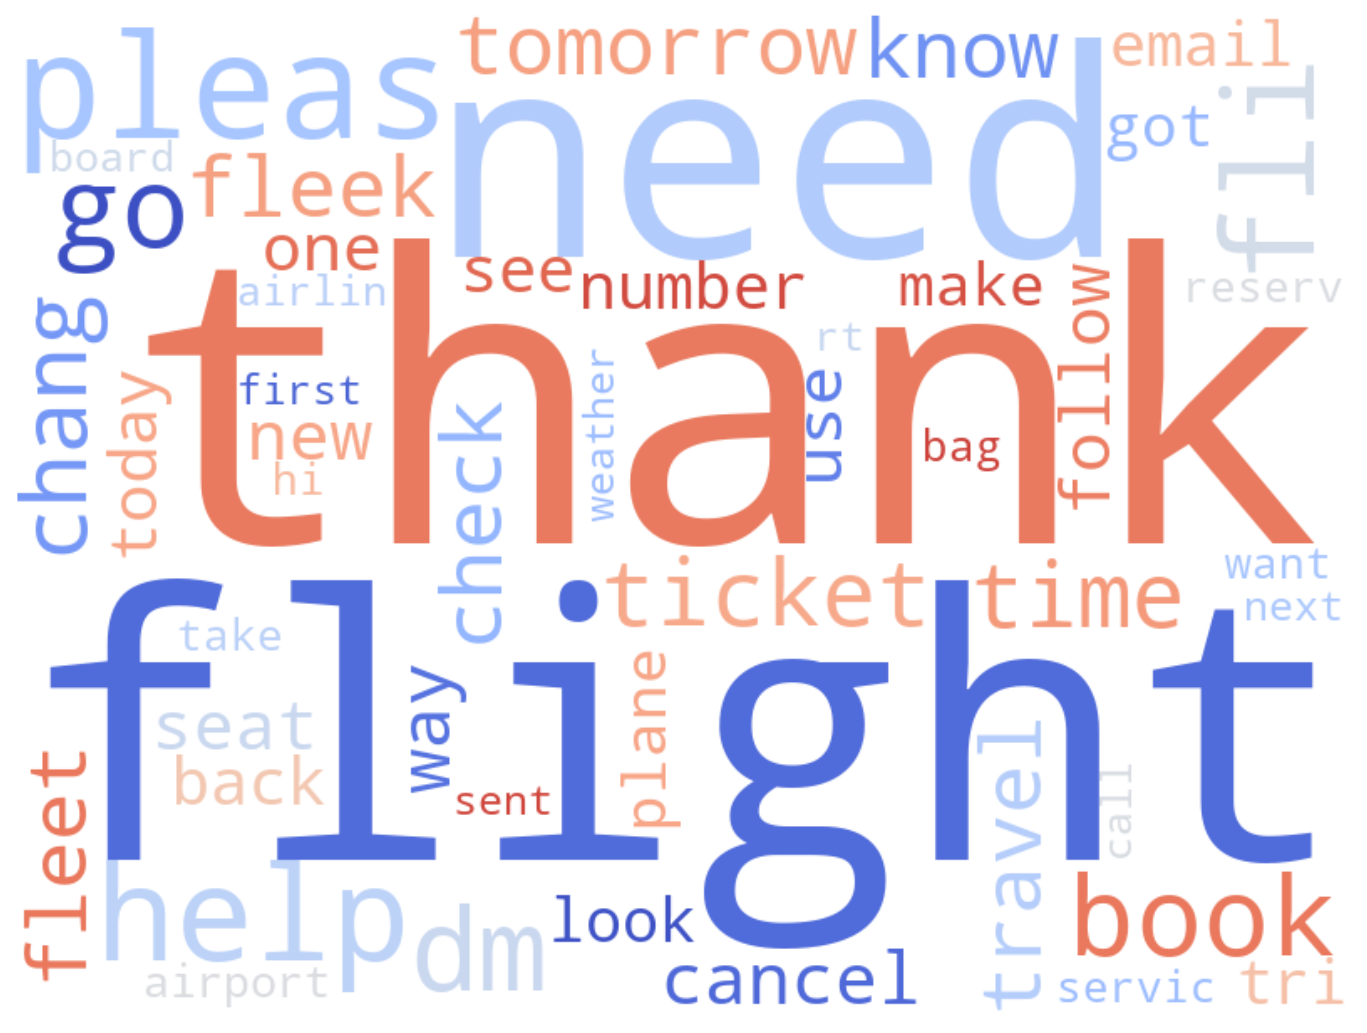

In [166]:
#plot word cloud for neutral
wc_neu = WordCloud(max_words=50, width=800, height=600, 
              background_color='white', min_font_size =10, colormap='coolwarm',collocations=False).generate(neutral_text)

plt.figure(figsize=(12,12))
plt.imshow(wc_neu,interpolation='bilinear')
plt.axis("off")
plt.savefig('../figure/neu_wordcloud.png');

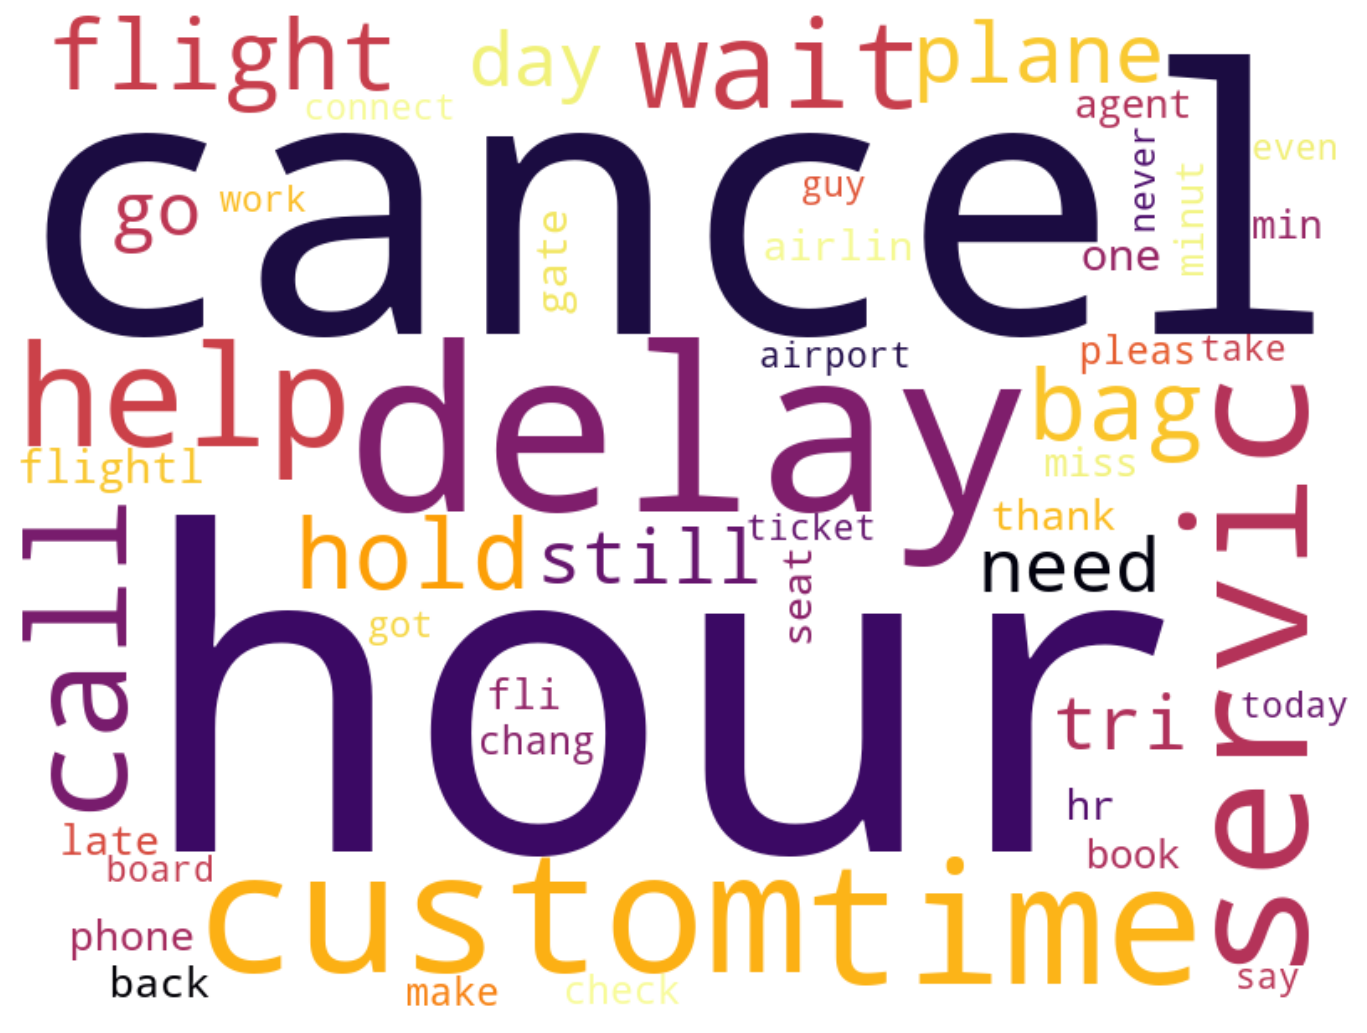

In [167]:
#plot word cloud for negative
wc_neg = WordCloud(max_words=50, width=800, height=600, 
              background_color='white', min_font_size =10,colormap='inferno',collocations=False).generate(negative_text)

plt.figure(figsize=(12,12))
plt.imshow(wc_neg,interpolation='bilinear')
plt.axis("off")
plt.savefig('../figure/neg_wordcloud.png');

#### Positive Sentiment - unigram

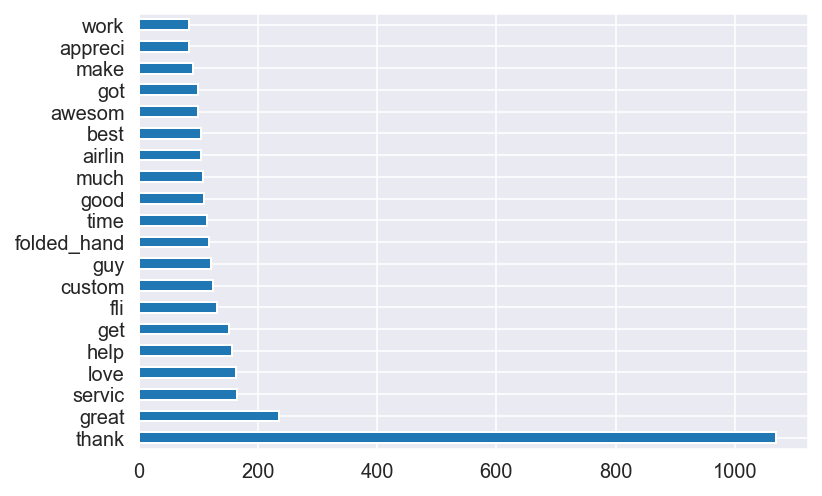

In [168]:
wordcount_df = pd.DataFrame(cvec.fit_transform([positive_text]).todense(),
                           columns=cvec.get_feature_names())

wordcount_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')


#### Neutral - unigram 

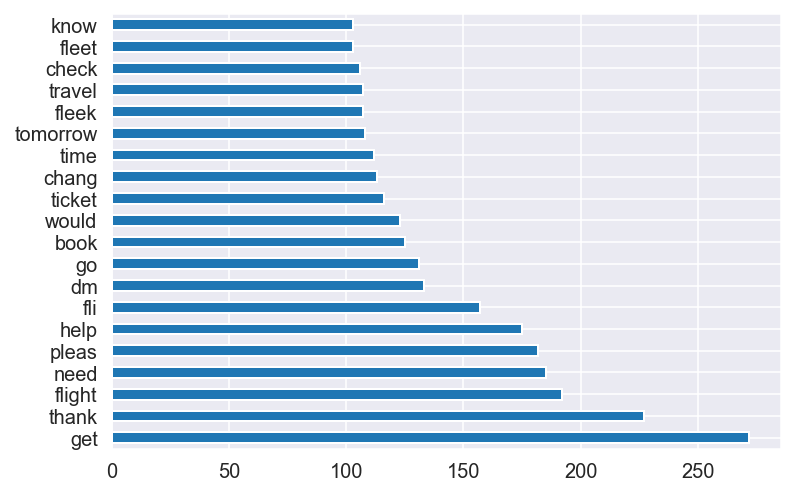

In [169]:
wordcount_neu = pd.DataFrame(cvec.fit_transform([neutral_text]).todense(),
                           columns=cvec.get_feature_names())

wordcount_neu.sum().sort_values(ascending=False).head(20).plot(kind='barh')

#### Negative Sentiment - unigram

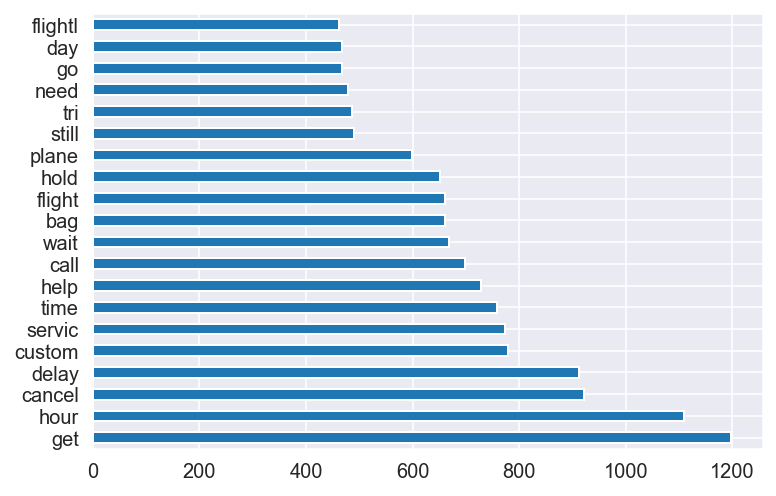

In [69]:
wordcount_neg = pd.DataFrame(cvec.fit_transform([negative_text]).todense(),
                           columns=cvec.get_feature_names())

wordcount_neg.sum().sort_values(ascending=False).head(20).plot(kind='barh')

###### Considering Bigrams

- Count Vectorizer to get most common words by sentiment

In [171]:
# Instantiate the "CountVectorizer" object with bi-gram
cvec_gram = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             ngram_range = (2,2),
                             max_features = 5000) #this is maximum features, to get top 5000 words

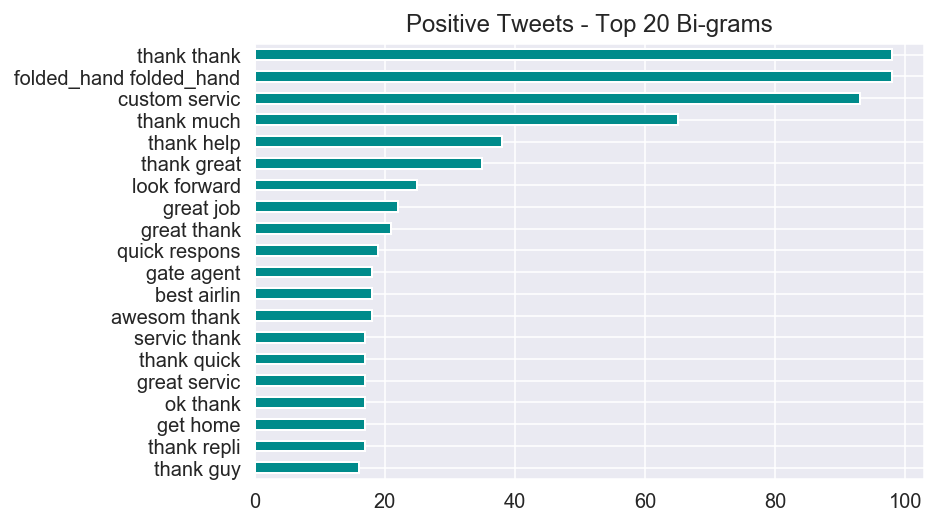

In [238]:
wordcount_df = pd.DataFrame(cvec_gram.fit_transform([positive_text]).todense(),
                           columns=cvec_gram.get_feature_names())

wordcount_df.sum().sort_values(ascending=False).head(20).plot(kind='barh',color='darkcyan')
plt.gca().invert_yaxis()
plt.title('Positive Tweets - Top 20 Bi-grams');
plt.savefig('../figure/PosTweetBigarms')

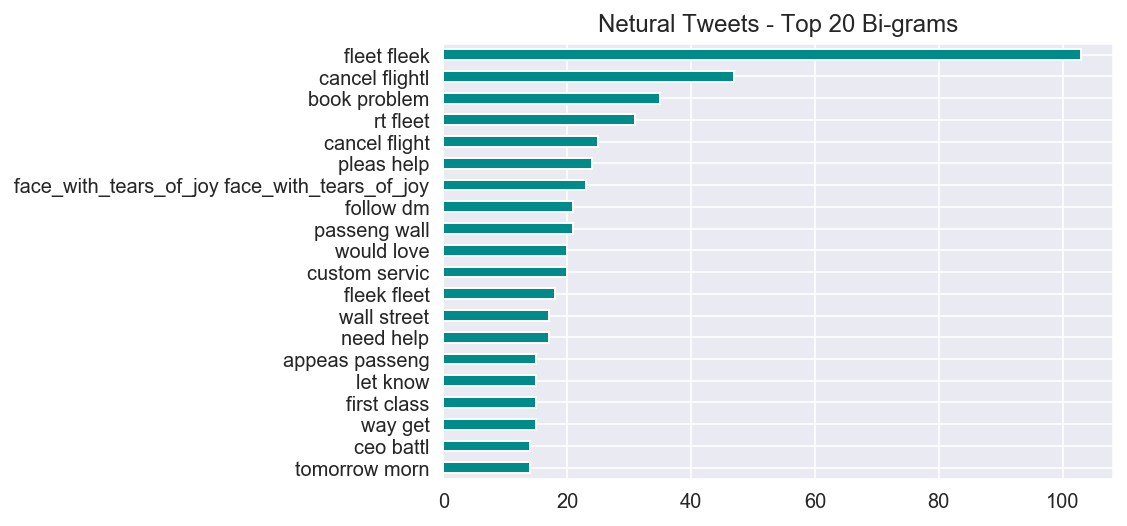

In [239]:
wordcount_neu = pd.DataFrame(cvec_gram.fit_transform([neutral_text]).todense(),
                           columns=cvec_gram.get_feature_names())

wordcount_neu.sum().sort_values(ascending=False).head(20).plot(kind='barh',color='darkcyan')
plt.gca().invert_yaxis()
plt.title('Netural Tweets - Top 20 Bi-grams');
plt.savefig('../figure/NeuTweetBigarms')

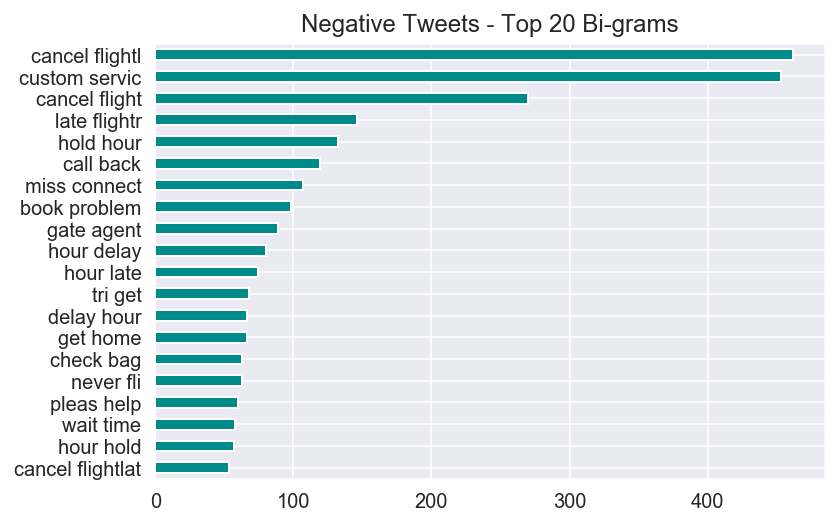

In [240]:
wordcount_neg = pd.DataFrame(cvec_gram.fit_transform([negative_text]).todense(),
                           columns=cvec_gram.get_feature_names())

wordcount_neg.sum().sort_values(ascending=False).head(20).plot(kind='barh',color='darkcyan')
plt.gca().invert_yaxis()
plt.title('Negative Tweets - Top 20 Bi-grams');
plt.savefig('../figure/NegTweetBigarms')

## Exporting Data
---

In [74]:
X = tweets_clean
y = tweets['airline_sentiment']

In [75]:
tweets_clean_1 = pd.merge(X,y,how='left',left_index=True, right_index=True)

In [76]:
tweets_clean_1

,text,airline_sentiment
0,said,1
1,plu ad commerci experi tacki,2
2,today must mean need take anoth trip,1
3,realli aggress blast obnoxi entertain guest fa...,0
4,realli big bad thing,0
...,...,...
14635,thank got differ chicago,2
14636,leav minut late warn commun minut late call sh...,0
14637,pleas bring american airlin blackberry10,1
14638,money chang answer phone suggest make commit,0


In [77]:
tweets_clean_1['text'].isnull().sum()

0

In [78]:
#export file to csv 
tweets_clean_1.to_csv('../datasets/tweets_clean_1.csv', index=False)

### Using Airline as a Feature

- Exporting data with the feature airline

In [79]:
tweets_clean_2 = pd.merge(X,tweets['airline'],how='left',left_index=True, right_index=True)

In [80]:
tweets_clean_2 = pd.merge(tweets_clean_2,y,how='left',left_index=True, right_index=True)

In [81]:
tweets_clean_2

,text,airline,airline_sentiment
0,said,Virgin America,1
1,plu ad commerci experi tacki,Virgin America,2
2,today must mean need take anoth trip,Virgin America,1
3,realli aggress blast obnoxi entertain guest fa...,Virgin America,0
4,realli big bad thing,Virgin America,0
...,...,...,...
14635,thank got differ chicago,American,2
14636,leav minut late warn commun minut late call sh...,American,0
14637,pleas bring american airlin blackberry10,American,1
14638,money chang answer phone suggest make commit,American,0


In [82]:
tweets_clean_2 = pd.get_dummies(tweets_clean_2, columns=['airline'], drop_first=True)

In [83]:
tweets_clean_2

,text,airline_sentiment,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America
0,said,1,0,0,0,0,1
1,plu ad commerci experi tacki,2,0,0,0,0,1
2,today must mean need take anoth trip,1,0,0,0,0,1
3,realli aggress blast obnoxi entertain guest fa...,0,0,0,0,0,1
4,realli big bad thing,0,0,0,0,0,1
...,...,...,...,...,...,...,...
14635,thank got differ chicago,2,0,0,0,0,0
14636,leav minut late warn commun minut late call sh...,0,0,0,0,0,0
14637,pleas bring american airlin blackberry10,1,0,0,0,0,0
14638,money chang answer phone suggest make commit,0,0,0,0,0,0


In [84]:
#export file to csv 
tweets_clean_2.to_csv('../datasets/tweets_clean_2.csv', index=False)

<a id='Preprocessing2'></a>

## Alternative Data Cleaning Methods to Try to Improve Score
---

Approach:
2. Retaining Stopwords 

##### Approach #2:

Main Difference: Stop words were not removed 
- Convert to lowercase
- Remove weblinks
- Remove airline tags (@, #??)
- Convert emojis to words using emoji library 
- Remove punctuations 
- Lemmatize & stem

In [3]:
def review_text_2(text):
    
    #1. convert words to lower 
    text = text.lower()

    #2. remove weblinks 
    text =re.sub(r"http\S+","",str(text))

    #3. remove tags
    text =re.sub(r"@\S+","",str(text))
    
    #4. remove parses
    text =re.sub(r"&\S+","",str(text))

    #5. convert emoji to text
    text = emoji.demojize(text, delimiters=(" ", ""))

    #6. tokenize words 
    tokenizer = RegexpTokenizer('[a-z]\w+')
    words = tokenizer.tokenize(text)
    
#     #7. remove stopwords
#     #   convert stopwords to set, as searching a set is faster than a list
#     addn_words=['flight']
#     stops = stopwords.words('english')
#     stops.extend(addn_words)
    
#     meaningful_words = [w for w in words if w not in stops]
    
    #8. lemmatize words 
    lem_words = [lemmatizer.lemmatize(i) for i in words]

    #9. stem words 
    stem_words = [p_stemmer.stem(i) for i in lem_words]
    
    #10. stem text 
    stem_text = " ".join(stem_words)
    
    #10. stem text 
    if stem_text == "":
        stem_text = stem_text.replace("",'0')
    
    return (stem_text)

In [86]:
tweets_clean_3 = tweets_df['text'].apply(review_text_2)

In [87]:
X3 = tweets_clean_3
y3 = tweets['airline_sentiment']

In [88]:
tweets_clean_3 = pd.merge(X3,y3,how='left',left_index=True, right_index=True)

In [89]:
tweets_clean_3

,text,airline_sentiment
0,what said,1
1,plu you ve ad commerci to the experi tacki,2
2,didn today must mean need to take anoth trip,1
3,it realli aggress to blast obnoxi entertain in...,0
4,and it realli big bad thing about it,0
...,...,...
14635,thank you we got on differ flight to chicago,2
14636,leav over minut late flight no warn or commun ...,0
14637,pleas bring american airlin to blackberry10,1
14638,you have my money you chang my flight and don ...,0


In [52]:
#export file to csv 
tweets_clean_3.to_csv('../datasets/tweets_clean_3.csv', index=False)

In [6]:
review_text_2('Hey @AmericanAir ! How is a round trip to Rome $1900 but when I make it just one way, the same exact flight is $3,670')

'hey how is round trip to rome but when make it just one way the same exact flight is'